# Face Recognition Model Using TensorFlow Keras

This notebook outlines the process of building a convolutional neural network (CNN) for face classification using TensorFlow Keras. We have a dataset with 3 images per person for 3 known individuals (Mariam, Muhirwa, Noella), stored in the directory known_faces with subdirectories for each person. The model will classify images into one of the 3 known classes. To handle "unrecognized" faces, we'll use a confidence threshold during inference: if the maximum predicted probability is below 0.8, classify as "unrecognized".

Since the dataset is small (9 images total), we'll use transfer learning with MobileNetV2, data augmentation (including rotation, shifts, zoom, flip, and custom blur using Gaussian filter), and evaluate with metrics like accuracy, precision, recall, F1-score, and confusion matrix.

**Note:** This is a demo; with such small data, the model may overfit. In practice, collect more data, especially for an "unknown" class.

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.ndimage import gaussian_filter

import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Rescaling
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

%matplotlib inline

2025-11-16 14:16:08.537303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configuration

In [2]:
# disable GPU detection (comment out to enable GPU)
tf.config.set_visible_devices([], 'GPU')

GENERATE_MORE_AUGMENTED_DATA = False

## Data Loading
We'll load all images and their labels manually since the dataset is small. Assume the directory structure:

``` bash
known_faces/
    [Name]/
        [Name] 1.jpeg
        [Name] 2.jpeg
        [Name] 3.jpeg
```

Images are resized to 224x224 (standard for MobileNetV2).

In [3]:
data_dir = '../raw/images/known_faces'
img_size = (224, 224)
batch_size = 2  # Small due to dataset size
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
num_classes = len(classes)

print(f'Found {num_classes} classes: {classes}')

Found 4 classes: ['Mariam', 'Noella', 'Egide', 'JD']


In [4]:
# Load images and labels
images = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpeg', '.jpg')):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_idx)  # 0: Mariam, 1: Muhirwa, 2: Noella

images = np.array(images)
labels = np.array(labels)

print(f'Loaded {len(images)} images with shape {images.shape}')

Loaded 12 images with shape (12, 224, 224, 3)


## Data Sample

Show imported images

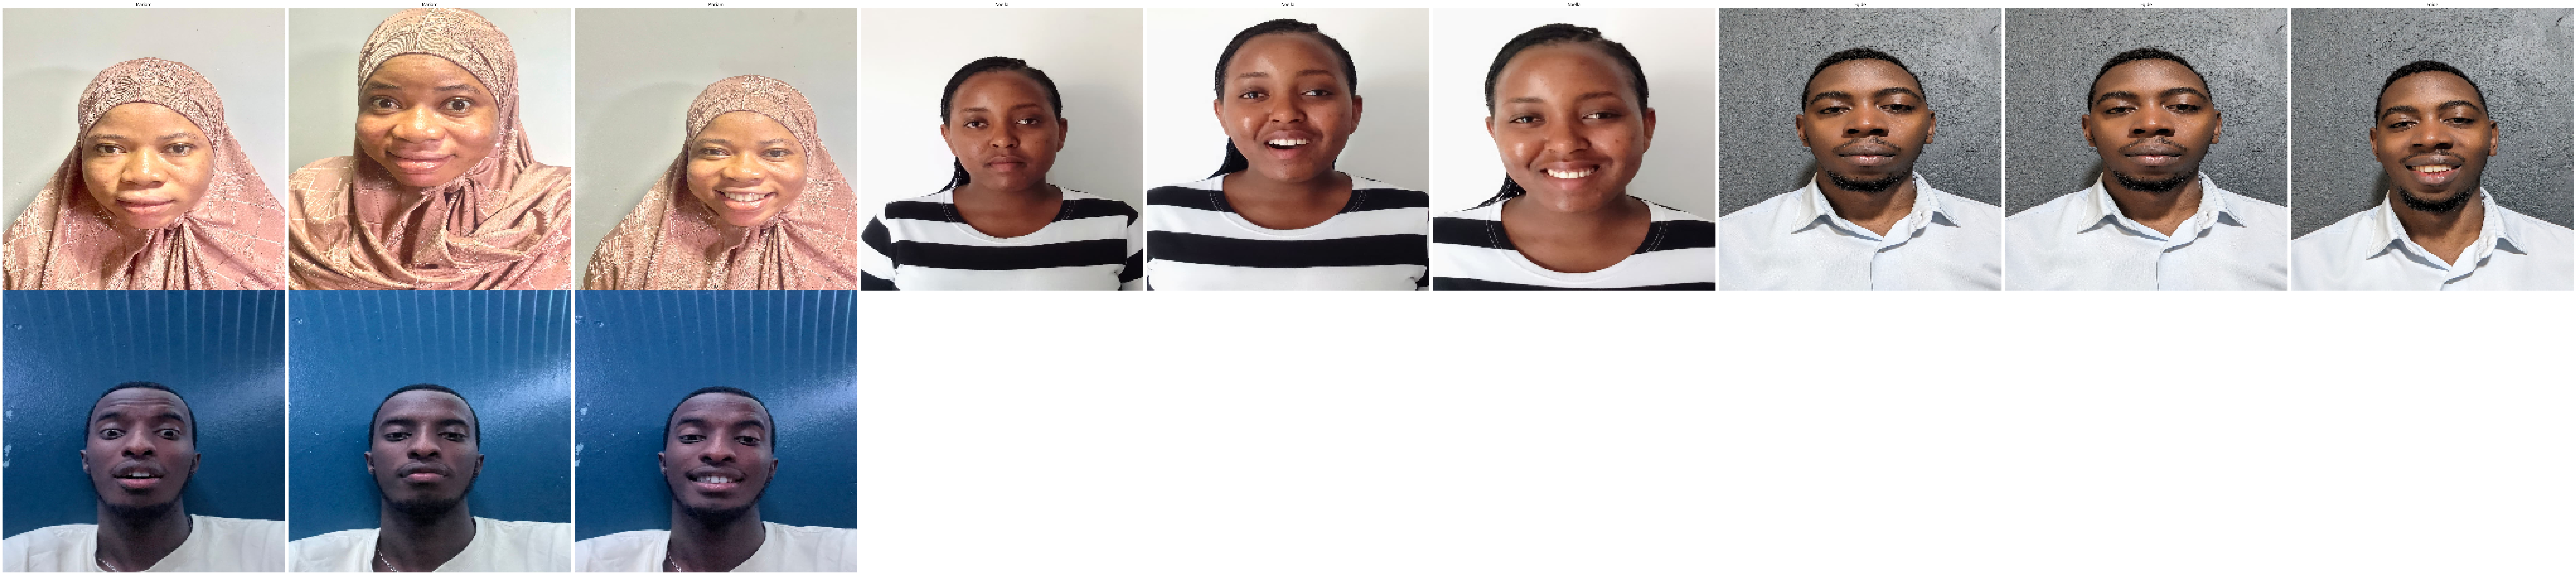

In [7]:
# Updated plot_images to accept label_indices (avoids global labels dependency)
def plot_images(images: np.ndarray, label_indices: np.ndarray = None, title_prefix: str = ""):
    n_images = len(images)
    ncols = 9  # Can adjust, but fine for large n_images
    nrows = np.ceil(n_images / ncols).astype(int)

    fig, axes = plt.subplots(nrows, ncols, figsize=(img_size[0]/20 * ncols, img_size[1]/20 * nrows))
    axes = axes.flat if nrows * ncols > 1 else [axes]  # Handle single axis case

    for i, ax in enumerate(axes):
        if i < n_images:
            img = images[i].copy()  # Avoid modifying original
            if img.max() > 1.0:
                img /= 255.0
            img = np.clip(img, 0, 1)  # Ensure no values outside [0,1]
            ax.imshow(img)
            
            # Set title with prefix and class if labels provided
            title = title_prefix if title_prefix else ""
            if label_indices is not None and i < len(label_indices):
                if title:
                    title += " - "
                title += classes[label_indices[i]]
            ax.set_title(title)
            ax.axis('off')
        else:
            fig.delaxes(ax)  # Remove unused axes to avoid empty plots

    plt.tight_layout()
    plt.show()

plot_images(images[:12], label_indices=labels[:12])  # Plot first 12 images

## Data Processing and Augmentation

Define a custom preprocessing function for random blur (Gaussian). We'll use ImageDataGenerator for augmentation on training data: rotation, shifts, shear, zoom, flip. Rescale all to [0,1].

In [8]:
def custom_preprocess(image):
    if np.random.rand() < 0.5:  # Apply blur with 50% chance
        sigma = np.random.uniform(0.5, 2.0)
        image = gaussian_filter(image, sigma=sigma)
    return image

# Train generator with augmentation and custom blur
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocess
)

# Test/Val generator: only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

## Data Splitting

Split into train (2 per class ~6 images) and test (1 per class ~3 images). Use stratify for balance.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.33, stratify=labels, random_state=42
)

# Convert labels to categorical (one-hot)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

print(f'Train: {X_train.shape[0]} images, Test: {X_test.shape[0]} images')

Train: 8 images, Test: 4 images


## Generate Augmented data

Generating more augmented data for increasing model precission

In [11]:
# Function to generate augmented images
def generate_augmented_images(generator, num_images):
    generated_images = []
    generated_labels = []
    batches_needed = int(np.ceil(num_images / generator.batch_size))
    step_count = 0
    for batch in generator:
        images, labels = batch
        generated_images.extend(images)
        generated_labels.extend(np.argmax(labels, axis=1))
        step_count += 1
        if step_count >= batches_needed:
            break
    # Trim to exact num_images (in case last batch overflows)
    generated_images = generated_images[:num_images]
    generated_labels = generated_labels[:num_images]
    return np.array(generated_images), np.array(generated_labels)

# Generate augmented images only if not already done
if GENERATE_MORE_AUGMENTED_DATA and X_train.shape[0] <= (len(images) - y_test.shape[0]):
    # Reset generator for fresh augmentations
    aug_generator = train_datagen.flow(X_train, y_train_cat, batch_size=batch_size)

    # Generate 100 augmented images
    num_aug = 100
    aug_images, aug_labels = generate_augmented_images(aug_generator, num_aug)
    print(f'Generated {len(aug_images)} augmented images with shape {aug_images.shape}')

    # Scale augmented images back to [0, 255] to match X_train
    aug_images_scaled = (aug_images * 255).astype(np.float32)  # Keep as float32 for consistency
    
    # Expand the dataset
    X_train = np.concatenate((X_train, aug_images_scaled), axis=0)
    y_train = np.concatenate((y_train, aug_labels), axis=0)
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)

## Preview the train and test data

==============Expanded training set==========
X_train shape: (8, 224, 224, 3)
X_test shape: (4, 224, 224, 3)
y_train shape: (8,)
y_train_cat shape: (8, 4)
y_test shape: (4,)
y_test_cat shape: (4, 4)

Preview training images (real + augmented):


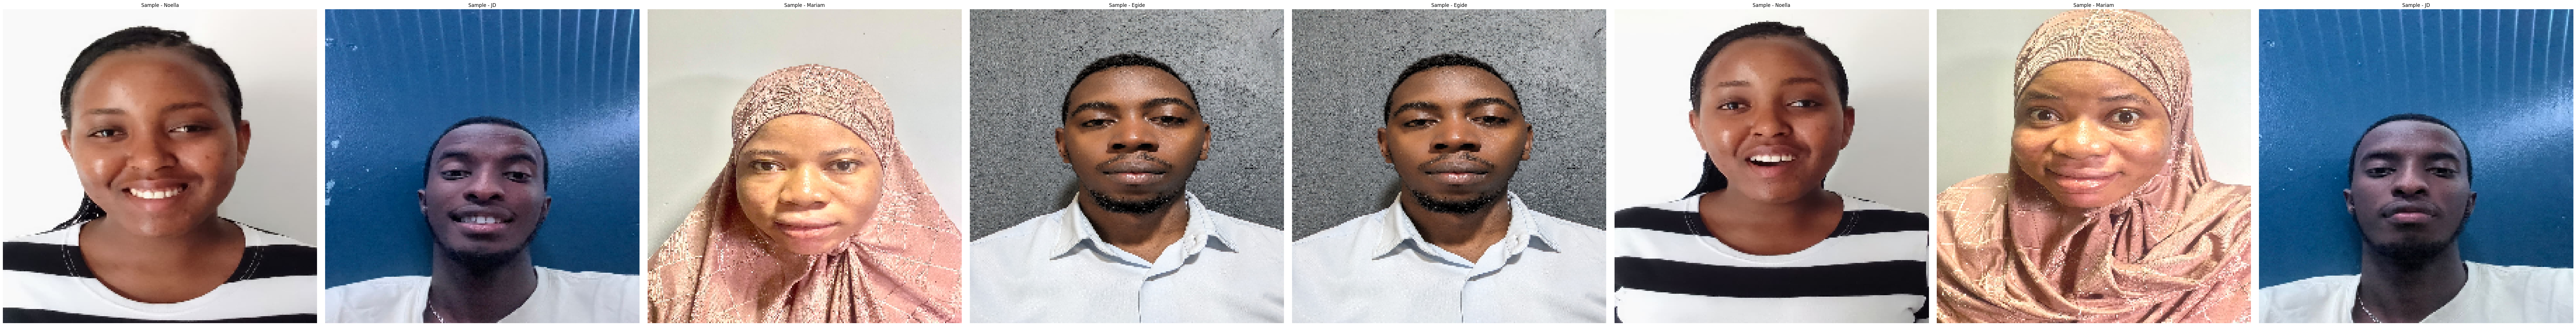

In [12]:
print(f'==============Expanded training set==========')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_train_cat shape: {y_train_cat.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_test_cat shape: {y_test_cat.shape}')

print("\nPreview training images (real + augmented):")
plot_images(X_train[:27], label_indices=y_train[:27], title_prefix="Sample")  # Plot first 27 images

## Model Creation

Use pre-trained MobileNetV2 as base (convolutions for feature extraction), add classifier head.

In [13]:
# Load pre-trained MobileNetV2 (without top classifier)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze base layers
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'f1_score', 'recall'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training and Metrics

Train with augmented generator. Evaluate on test set, compute metrics

Epoch 1/50


/home/degide/.mlvenv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-11-16 14:18:16.988604: I external/local_xla/xla/service/service.cc:163] XLA service 0x7aedb0060b00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-16 14:18:16.988625: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-11-16 14:18:17.139249: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/4 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.5000 - f1_score: 0.2500 - loss: 3.6138 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1763295498.697735   13862 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 987ms/step - accuracy: 0.3750 - f1_score: 0.3667 - loss: 2.1658 - precision: 0.2500 - recall: 0.1250 - val_accuracy: 0.5000 - val_f1_score: 0.3333 - val_loss: 1.3151 - val_precision: 1.0000 - val_recall: 0.2500 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.3750 - f1_score: 0.3333 - loss: 1.1144 - precision: 0.7500 - recall: 0.3750 - val_accuracy: 0.5000 - val_f1_score: 0.4167 - val_loss: 0.9838 - val_precision: 1.0000 - val_recall: 0.2500 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - accuracy: 0.1250 - f1_score: 0.0833 - loss: 3.1346 - precision: 0.1429 - recall: 0.1250 - val_accuracy: 0.7500 - val_f1_score: 0.6667 - val_loss: 0.8761 - val_precision: 0.6667 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.3750 - f1_score: 0.3500 - loss: 1.3715 - precision: 0.4286 - recall: 0.3750 - val_accuracy: 0.5000 - val_f1_score: 0.3750 - v

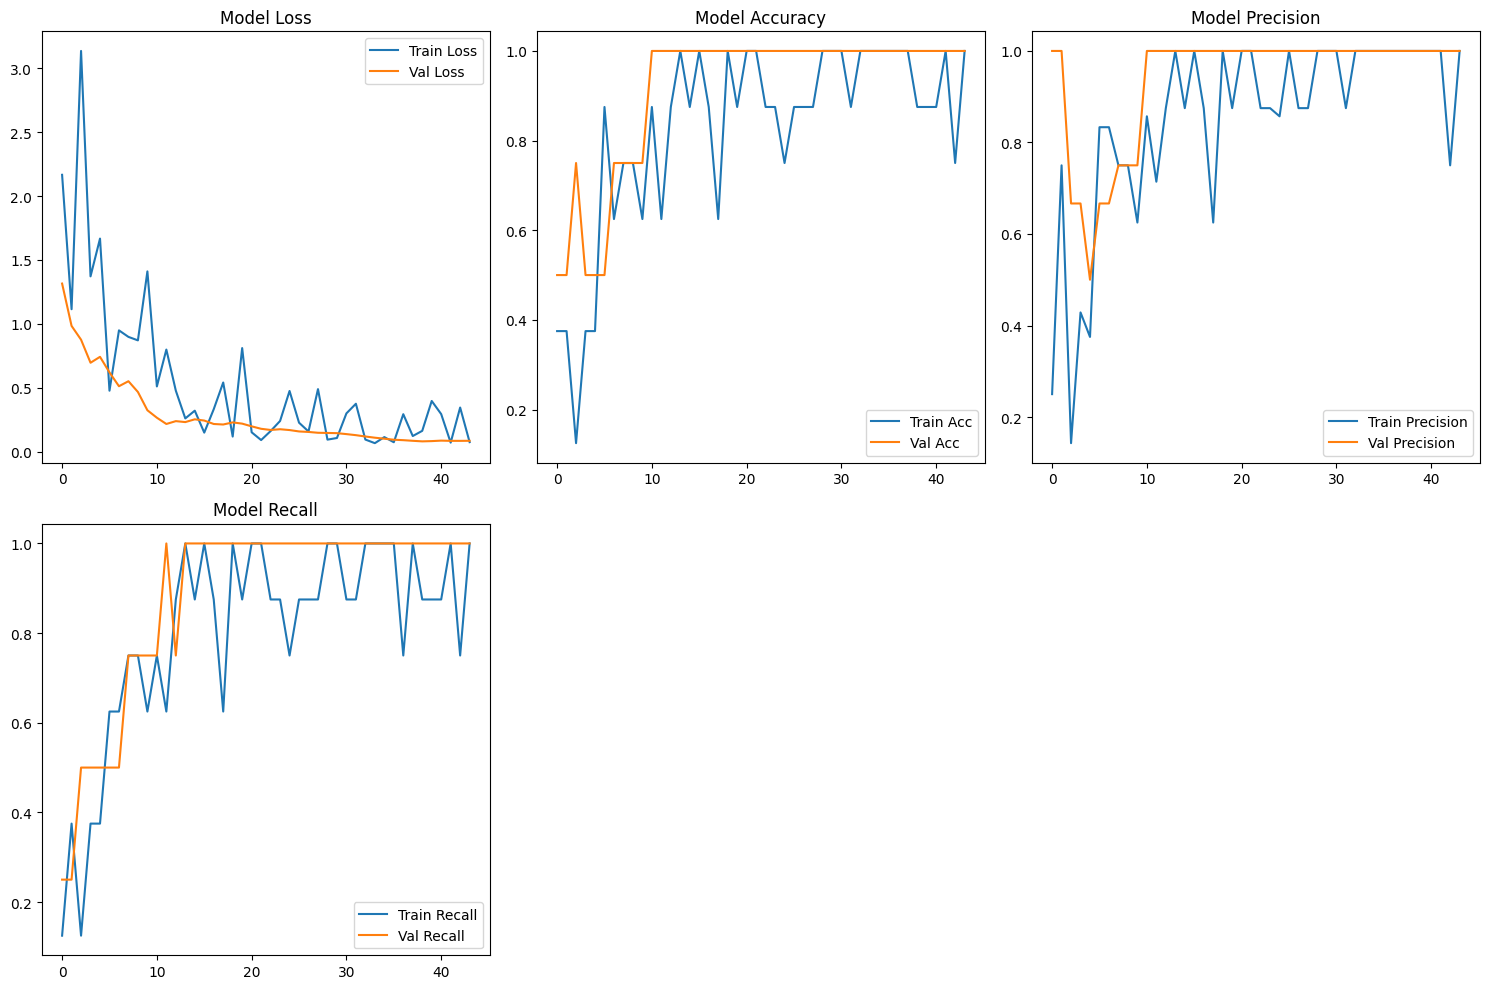

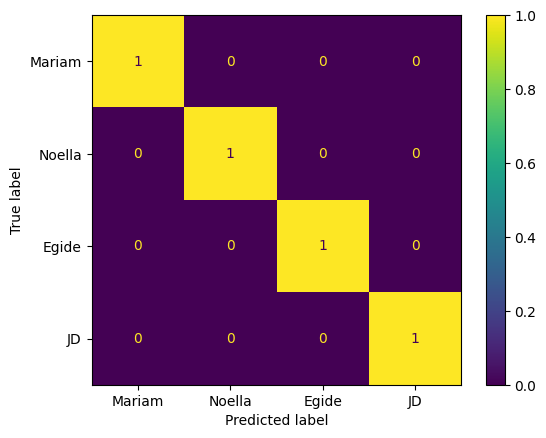

In [14]:
epochs = 50  # Increase epochs; early stopping will handle stopping

# Flow generators (same as before)
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test_cat, batch_size=batch_size, shuffle=False)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Stop after 5 epochs with no improvement
    verbose=1,               # Print when stopping
    restore_best_weights=True  # Restore model weights from best epoch
)

# Optional: Reduce learning rate on plateau (complements early stopping)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# Train with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size,
    callbacks=[early_stopping, reduce_lr]  # Add callbacks here
)

# Predict on test
test_steps = np.ceil(len(X_test) / batch_size).astype(int)
y_pred_prob = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(y_pred_prob, axis=1)

print(f"\nTraining stopped after {len(history.history['loss'])} epochs\n")

# Metrics
print(classification_report(y_test, y_pred, target_names=classes))

# Plot training history (shows where early stopping kicked in)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Model Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Model Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

## Saving Model

Save the trained model for later use.

In [15]:
# Create pipeline model with preprocessing from the base model
pipeline_model = Sequential([
    Input(shape=(224, 224, 3)),
    Rescaling(1./255),  # Same as /255.0
    model
], name="face_recognition_pipeline")

pipeline_model.save('../../models/face_classification_model.keras')
np.save('../../models/face_classification_model_class_names.npy', classes, allow_pickle=True)

print('Model Pipeline saved as face_classification_model.keras')

Model Pipeline saved as face_classification_model.keras


## Usage Example

Load the model and classify a new image. If max probability < 0.8, classify as "unrecognized".

In [17]:
import tensorflow as tf
import numpy as np

# disable GPU detection (comment out to enable GPU in case supported)
tf.config.set_visible_devices([], 'GPU')

# Load model
loaded_model = tf.keras.models.load_model('../../models/face_classification_model.keras')
class_names = np.load('../../models/face_classification_model_class_names.npy', allow_pickle=True)

# Function to classify a new image
def classify_face(image_path, threshold=0.9):
    raw = tf.io.read_file(image_path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, 0)
    pred_prob = loaded_model(img)
    pred_prob = pred_prob.numpy().squeeze().astype(float)
    max_prob = np.max(pred_prob)
    if max_prob < threshold:
        return 'unrecognized', max_prob
    else:
        pred_class = np.argmax(pred_prob)
        return class_names[pred_class], max_prob


test_image_paths = ['../raw/images/unknown_faces/unknown1.png',
                    '../raw/images/unknown_faces/unknown2.jpeg',
                    '../raw/images/unknown_faces/unknown3.jpeg',
                    '../raw/images/unknown_faces/unknown4.jpeg',
                    '../raw/images/known_faces/Noella/Noella 1.jpeg',
                    '../raw/images/known_faces/Mariam/Mariam 2.jpeg',
                    '../raw/images/known_faces/JD/JD 3.jpeg',
                    '../raw/images/known_faces/Egide/Egide 1.jpg'
                ]
for test_image_path in test_image_paths:
    result, confidence = classify_face(test_image_path)
    print(f'Testing image: {test_image_path.split("/")[-1]}')
    print(f'Predicted: {result}, Probability: {confidence:.2f}\n')

Testing image: unknown1.png
Predicted: unrecognized, Probability: 0.65

Testing image: unknown2.jpeg
Predicted: unrecognized, Probability: 0.77

Testing image: unknown3.jpeg
Predicted: unrecognized, Probability: 0.81

Testing image: unknown4.jpeg
Predicted: unrecognized, Probability: 0.75

Testing image: Noella 1.jpeg
Predicted: Noella, Probability: 0.95

Testing image: Mariam 2.jpeg
Predicted: Mariam, Probability: 0.98

Testing image: JD 3.jpeg
Predicted: JD, Probability: 0.99

Testing image: Egide 1.jpg
Predicted: Egide, Probability: 0.92

